In [237]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

In [186]:
%matplotlib inline

In [200]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:10000], data[10000:15000]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/20))
	test = array(split(test, len(test)/20))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [59]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [109]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	print(actual.shape)
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [60]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [143]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=20):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [235]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="lstm2.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [240]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="ed_lstm.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [243]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="cnn_lstm.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

In [127]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [137]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :], predictions)
#	score, scores = 0, 0
	return score, scores, predictions

In [129]:
# load the new data file
dataset = read_csv('trainData_set1.csv')

In [144]:
# extracting a single feature
X0 = dataset.BIDASKIMBALANCE

In [201]:
# split into train and test
train, test = split_dataset(X0.values)

In [202]:
test.shape

(250, 20, 1)

In [238]:
# evaluate model and get scores
n_input = 60
score_lstm, scores_LSTM, predictions_LSTM = evaluate_model(train, test, n_input)


Epoch 00001: saving model to lstm2.hdf5

Epoch 00002: saving model to lstm2.hdf5

Epoch 00003: saving model to lstm2.hdf5
(250, 20, 1)


In [241]:
# evaluate model and get scores
n_input = 60
score_ED_LSTM, scores_ED_LSTM, predictions = evaluate_model(train, test, n_input)


Epoch 00001: saving model to ed_lstm.hdf5
(250, 20, 1)


In [244]:
# evaluate model and get scores
n_input = 60
score_CNN_LSTM, scores_CNN_LSTM, predictions_CNN = evaluate_model(train, test, n_input)


Epoch 00001: saving model to cnn_lstm.hdf5
(250, 20, 1)


In [193]:
# evaluate model and get scores
n_input = 20
score_cnn, scores_CNN_LSTM_ED, predictions = evaluate_model(train, test, n_input)

(700, 20, 1)


In [208]:
# evaluate model and get scores
n_input = 20
score_lstm, scores_LSTM, predictions = evaluate_model(train, test, n_input)

(250, 20, 1)


LSTM: [0.153] 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2
ED_LSTM: [0.170] 0.2, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2
CNN_LSTM: [0.168] 0.2, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2


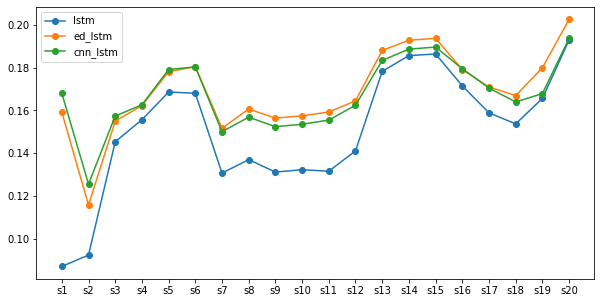

In [245]:
# summarize scores
summarize_scores('LSTM', score_lstm, scores_LSTM)
summarize_scores('ED_LSTM', score_ED_LSTM, scores_ED_LSTM)
summarize_scores('CNN_LSTM', score_CNN_LSTM, scores_CNN_LSTM)
# plot scores
days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10','s11', 's12', 's13', 's14', 's15', 's16', 's17','s18','s19','s20']
pyplot.figure(figsize=(10,5))
pyplot.plot(days, scores_LSTM, marker='o', label='lstm')
pyplot.plot(days, scores_ED_LSTM, marker='o', label='ed_lstm')
pyplot.plot(days, scores_CNN_LSTM, marker='o', label='cnn_lstm')
pyplot.legend()
pyplot.show()

In [134]:
len(X0[8:88])

80

In [135]:
test[:,1]

array([[-0.15363863],
       [ 0.0182711 ],
       [ 0.0170123 ],
       [-0.07504181],
       [-0.07440199],
       [-0.05295769],
       [-0.00076539],
       [-0.05956928],
       [-0.05336693]])

In [181]:
predictions.shape

(10, 20, 1)

In [177]:
predictions[0]

array([[0.1624855 ],
       [0.18480021],
       [0.19619197],
       [0.20233728],
       [0.20655884],
       [0.20893405],
       [0.21012604],
       [0.21064974],
       [0.2108132 ],
       [0.21079983],
       [0.21070789],
       [0.21059039],
       [0.21047135],
       [0.21036687],
       [0.21028064],
       [0.2102123 ],
       [0.21015967],
       [0.21012002],
       [0.21009064],
       [0.2100692 ]], dtype=float32)

In [179]:
import pandas as pd

In [210]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [211]:
predictionDF = pd.DataFrame(data=predictions, columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10','s11', 's12', 's13', 's14', 's15',
                                                       's16', 's17','s18','s19','s20'])

In [212]:
predictionDF.describe()

s1          s2          s3          s4          s5          s6  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.126541    0.112411    0.112677    0.098524    0.104248    0.113942   
std      0.347519    0.333611    0.328497    0.315798    0.324773    0.329770   
min     -0.770707   -0.735600   -0.743633   -0.705943   -0.654028   -0.684798   
25%     -0.173872   -0.178730   -0.166312   -0.175468   -0.183818   -0.172768   
50%      0.134564    0.118998    0.113954    0.105210    0.101671    0.113446   
75%      0.329290    0.310791    0.302588    0.292680    0.303211    0.309751   
max      1.012330    0.953443    0.958065    0.880937    0.937363    0.963950   

               s7          s8          s9         s10         s11         s12  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.092455    0.098423    0.092072    0.086081    0.065783    0.083268   
std      0.299900    0.298290    0.289905    0.286921    0.276602    0.286186   
min     -0.669002   -0.640954   -0.636972   -0.610810   -0.596857   -0.608298   
25%     -0.167373   -0.165006   -0.161272   -0.168982   -0.177632   -0.166649   
50%      0.106494    0.105937    0.096911    0.090588    0.071552    0.086610   
75%      0.268912    0.280541    0.266786    0.259742    0.232879    0.254066   
max      0.852730    0.848603    0.821270    0.805528    0.764938    0.814407   

              s13         s14         s15         s16         s17         s18  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.074435    0.069940    0.093050    0.094320    0.086451    0.081874   
std      0.276968    0.274466    0.284848    0.280507    0.274004    0.273122   
min     -0.598022   -0.600658   -0.611025   -0.557282   -0.532565   -0.584741   
25%     -0.174755   -0.172441   -0.155284   -0.156940   -0.160338   -0.160062   
50%      0.086771    0.078039    0.097317    0.098180    0.084150    0.087299   
75%      0.246258    0.237630    0.262812    0.263738    0.251181    0.247984   
max      0.754295    0.760254    0.808590    0.807990    0.790733    0.772743   

              s19         s20  
count  250.000000  250.000000  
mean     0.093556    0.092190  
std      0.284147    0.270670  
min     -0.531902   -0.496905  
25%     -0.163847   -0.153521  
50%      0.087603    0.086730  
75%      0.268953    0.256245  
max      0.816182    0.792085

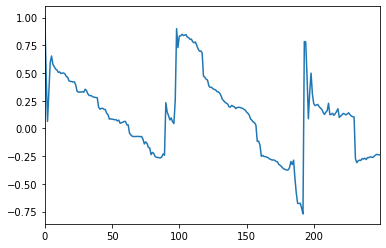

In [213]:
predictionDF['s1'].plot();

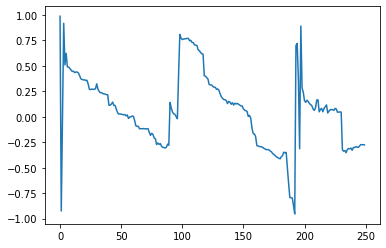

In [214]:
pyplot.plot(test[:, 0]);

In [216]:
t1 = dataset.TIME

In [217]:
t1[0]

'10:59:32.944'

In [218]:
t2 = dataset.TIME.shift(20)

In [220]:
from datetime import timedelta

In [222]:
t1_delta = timedelta(t1)

TypeError: unsupported type for timedelta days component: Series

In [223]:
t3 = pd.to_datetime(t1)

In [225]:
t4 = pd.to_datetime(t2)

In [226]:
t4[0] - t3[0]

NaT

In [234]:
t4[20].microsecond - t3[20].microsecond

719000